In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512551 sha256=90102b54a3ad3d0931e4a924d9b8da9b724eb2a93437976cc3773ee3f63f9ae1
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
%matplotlib inline
import random
from math import sqrt, log, floor
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error

sns.set(style='white')
# "fix" the randomness for reproducibility
random.seed(42)

In [ ]:
# load data
data = pd.read_csv('train.txt', header=None, delim_whitespace=True)
# data normalization
for column in range(2, 26):
    data[column] = (data[column] - data[column].mean()) / data[column].std()
data.shape

<ipython-input-5-c6e4f91859c5>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('train.txt', header=None, delim_whitespace=True)


(45918, 26)

In [ ]:
#exploring data
data[0].value_counts().describe()

,count
count,218.000000
mean,210.633028
std,43.595578
min,128.000000
25%,177.000000
50%,209.500000
75%,236.000000
max,357.000000


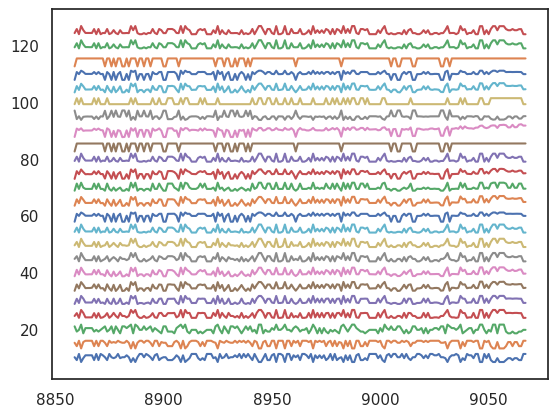

In [ ]:
serie = data[data[0]==43]
for i in range(2, 26):
    (serie[i]+5*i).plot(x=1)

In [ ]:
# group data by each timeserie
grouped = data.groupby(0)
series = [group.drop(labels=[0,1], axis=1) for name, group in grouped]
# number of clusters
k = 6
# length of chunks
chunk_length = 10
# go through groups and compute chunks and labels
train_set = []
true_labels = []
for serie in series:
    reversed_serie = serie.iloc[::-1]
    for i in range(len(serie) // chunk_length):
        chunk = reversed_serie[i*10:(i+1)*10]
        true_label = i
        train_set.append(chunk)
        true_labels.append(true_label)

In [ ]:
# sampling
n = 100
indices = random.sample(list(range(len(train_set))), k=n)
sample = [train_set[i] for i in indices]
sample_labels = [true_labels[i] for i in indices]

In [ ]:
# compute eucledean distance
euclidean_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        euclidean_distances[i,j] = euclidean(sample[i].values.flatten(),
                                             sample[j].values.flatten())

In [ ]:
# compute distances using RMSE
rmse_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rmse_distances[i,j] = sqrt(mean_squared_error(sample[i].values.flatten(),
                                                      sample[j].values.flatten()))

In [ ]:
# compute distances using DTW
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist

dtw_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dtw_distances[i,j] = dtw(sample[i], sample[j])

In [ ]:
# compute distances using LCSS

# function for LCSS computation
# based on implementation from
# https://rosettacode.org/wiki/Longest_common_subsequence
def lcs(a, b):
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

lcs_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        lcs_distances[i,j] = multidim_lcs(sample[i], sample[j])

<ipython-input-13-4f233cc67ebe>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  a = a.applymap(discretise)
<ipython-input-13-4f233cc67ebe>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  b = b.applymap(discretise)


<Axes: >

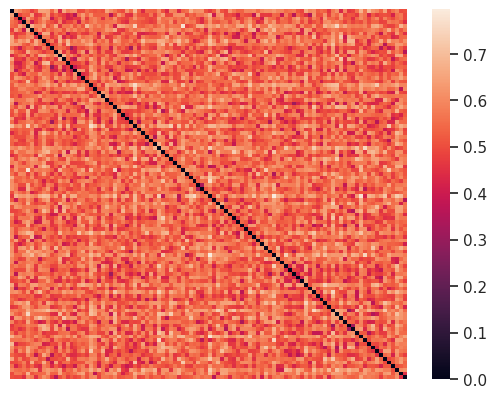

In [ ]:
sns.heatmap(lcs_distances, xticklabels=False, yticklabels=False)

In [ ]:
#clustering algo
k = 6
y_pred_km_euc = KMeans(n_clusters=k).fit_predict(euclidean_distances)
y_pred_km_dtw = KMeans(n_clusters=k).fit_predict(dtw_distances)
y_pred_km_rmse = KMeans(n_clusters=k).fit_predict(rmse_distances)
y_pred_km_lcs = KMeans(n_clusters=k).fit_predict(lcs_distances)

In [ ]:
y_pred_hac_euc = AgglomerativeClustering(n_clusters=k)\
                 .fit_predict(euclidean_distances)
y_pred_hac_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_distances)
y_pred_hac_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(rmse_distances)
y_pred_hac_lcs = AgglomerativeClustering(n_clusters=k).fit_predict(lcs_distances)

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:
#evaluate
# True label normalisation
log_base = max(true_labels)**(1 / k) + 0.05
normalised_true_labels = [floor(log(l+1, log_base)) for l in sample_labels]

In [ ]:
print('Normalized Mutual Information')
print('K-means + Eucledean: ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_euc))
print('K-means + RMS:       ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_rmse))
print('K-means + DTW:       ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_dtw))
print('K-means + LCSS:      ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_lcs))
print('HAC + Eucledean:     ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_euc))
print('HAC + RMS:           ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_rmse))
print('HAC + DTW:           ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_dtw))
print('HAC + LCSS:          ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_lcs))

Normalized Mutual Information
K-means + Eucledean:  0.08068783042994666
K-means + RMS:        0.049061567537667945
K-means + DTW:        0.1126256823140451
K-means + LCSS:       0.14826597452522716
HAC + Eucledean:      0.06642317331535197
HAC + RMS:            0.06642317331535197
HAC + DTW:            0.12896395495589852
HAC + LCSS:           0.20111732219942705


In [ ]:
print('Adjusted Rand Index')
print('K-means + Eucledean:  ', adjusted_rand_score(normalised_true_labels,
                                                    y_pred_km_euc))
print('K-means + RMS:       ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_km_rmse))
print('K-means + DTW:       ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_km_dtw))
print('K-means + LCSS:       ', adjusted_rand_score(normalised_true_labels,
                                                    y_pred_km_lcs))
print('HAC + Eucledean:     ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_euc))
print('HAC + RMS:           ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_rmse))
print('HAC + DTW:           ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_dtw))
print('HAC + LCSS:           ', adjusted_rand_score(normalised_true_labels,
                                                    y_pred_hac_lcs))

Adjusted Rand Index
K-means + Eucledean:   -0.003753399729852161
K-means + RMS:        -0.019366766752980828
K-means + DTW:        0.03060535543372992
K-means + LCSS:        0.008387314628237566
HAC + Eucledean:      -0.005269951522248419
HAC + RMS:            -0.005269951522248419
HAC + DTW:            0.005580384682393636
HAC + LCSS:            0.07594435793983294


<Axes: xlabel='0', ylabel='1'>

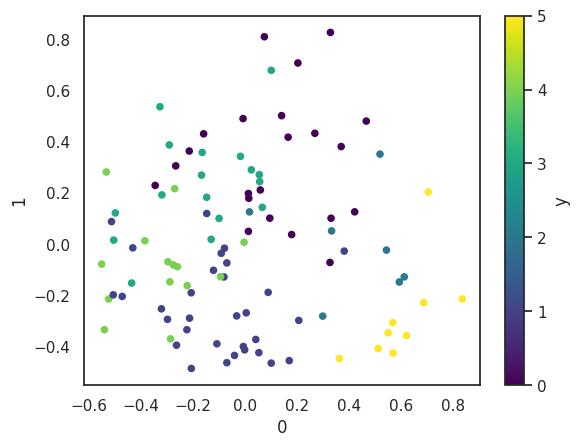

In [ ]:
#visualize clutering
pca = PCA(n_components=2)
emb = pd.DataFrame(pca.fit_transform(lcs_distances))
emb['y'] = y_pred_hac_lcs
emb['gt'] = normalised_true_labels
emb.plot(kind='scatter', x=0, y=1, c='y', cmap='viridis')

In [ ]:
# computeting features for a single chunk and sensor
def extract_featrues(chunk, s):
    column = chunk[s]
    slope = (column.iloc[-1]-column.iloc[0])/10
    return (column.std(), column.mean(), slope)

def compute_features_for_all_chunks(s):
    stds = []
    means = []
    slopes = []

    for chunk in sample:
        std, mean, slope = extract_featrues(chunk, s)
        stds.append(std)
        means.append(mean)
        slopes.append(slope)
    return pd.DataFrame({'std': stds, 'mean': means, 'slope': slopes,
                         'true_label': normalised_true_labels,
                         'cluster': y_pred_hac_lcs})

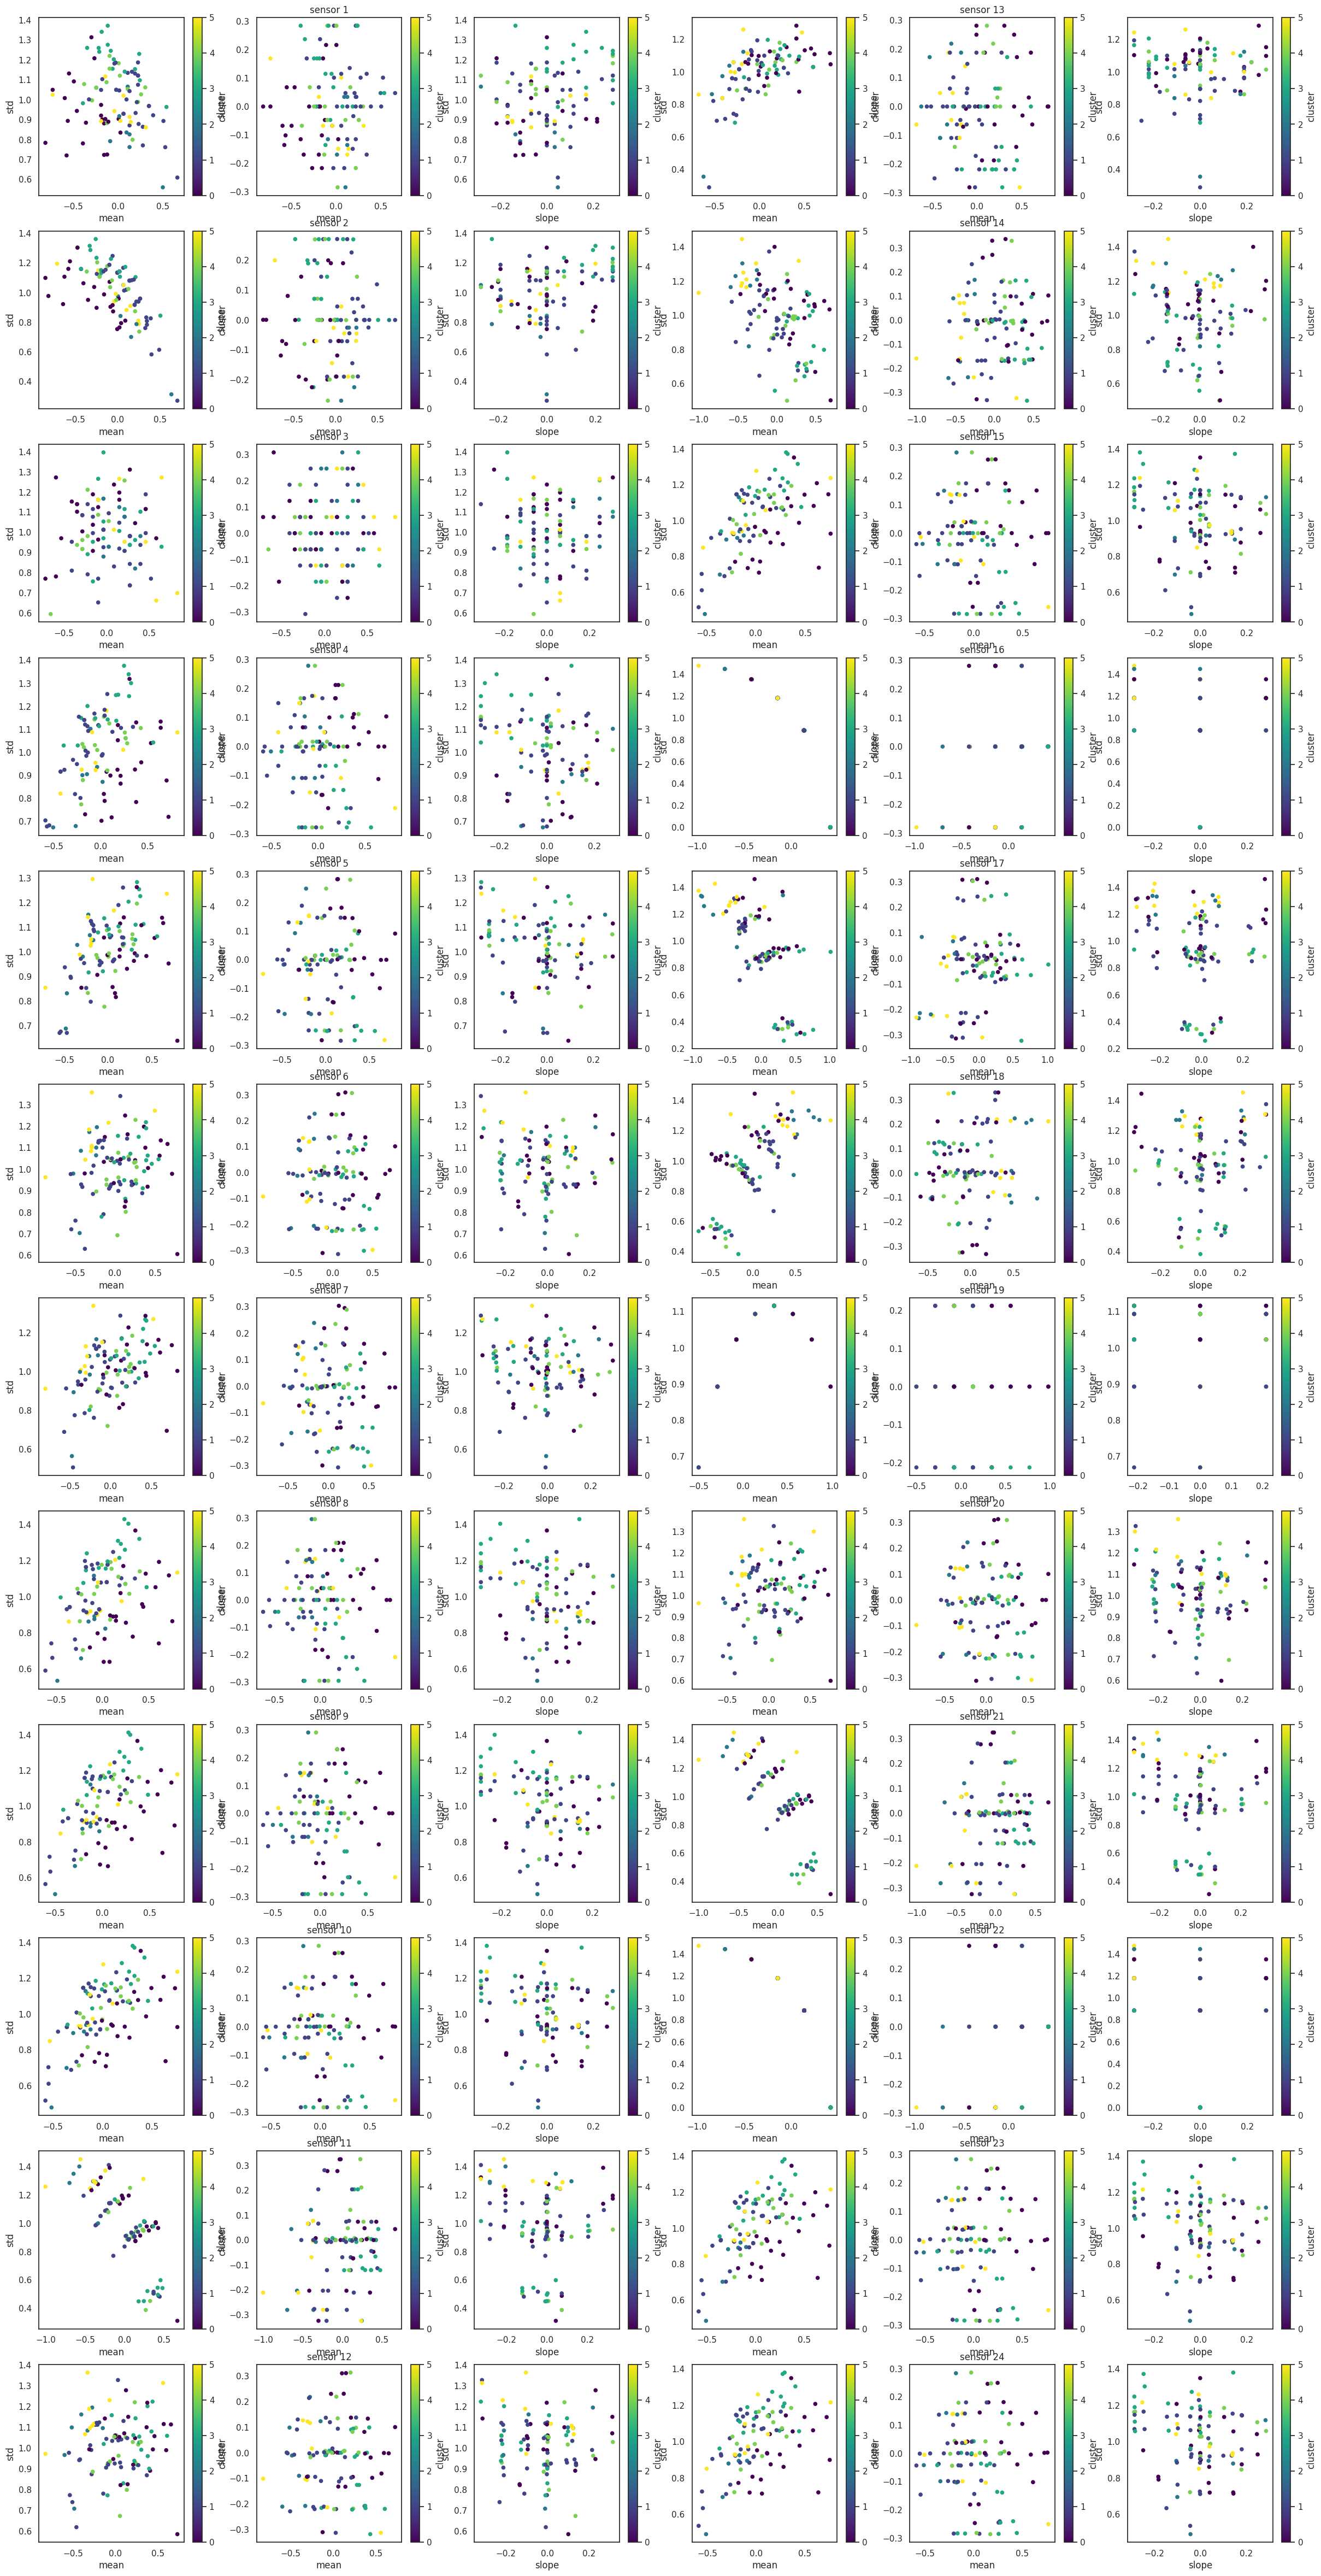

In [ ]:
sensor_max = 25
sensor_min = 2

f, axis = plt.subplots(12, 6, figsize=(30,60))
for s in range(sensor_min, sensor_max+1):
    features = compute_features_for_all_chunks(s)
    row = (s-sensor_min)%12
    col = (s-sensor_min)//12
    features.plot(kind='scatter', x='mean', y='std', c='cluster',
                  cmap='viridis', ax=axis[row][col*3])
    features.plot(kind='scatter', x='mean', y='slope', c='cluster',
                  cmap='viridis', ax=axis[row][col*3+1])
    features.plot(kind='scatter', x='slope', y='std', c='cluster',
                  cmap='viridis', ax=axis[row][col*3+2])
    axis[row][col*3+1].set_title('sensor ' + str(s-sensor_min+1))

<Axes: xlabel='mean', ylabel='std'>

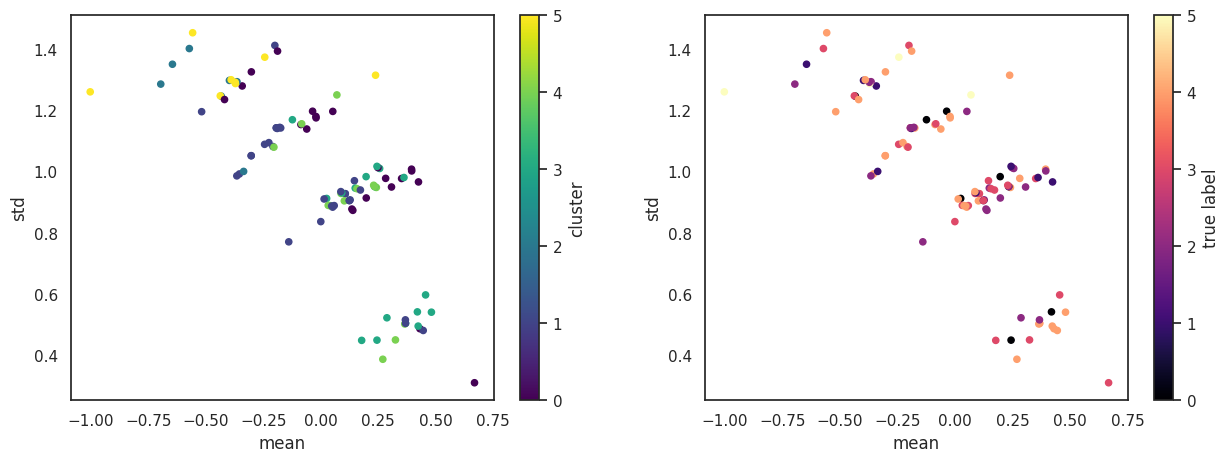

In [ ]:
# sensor 22
# mean x std
f, axis = plt.subplots(1, 2, figsize=(15,5))
features = compute_features_for_all_chunks(22)
features.plot(kind='scatter', x='mean', y='std', c='cluster',
              cmap='viridis', ax=axis[0])
features['true label'] = normalised_true_labels
features.plot(kind='scatter', x='mean', y='std', c='true label',
              cmap='magma', ax=axis[1])

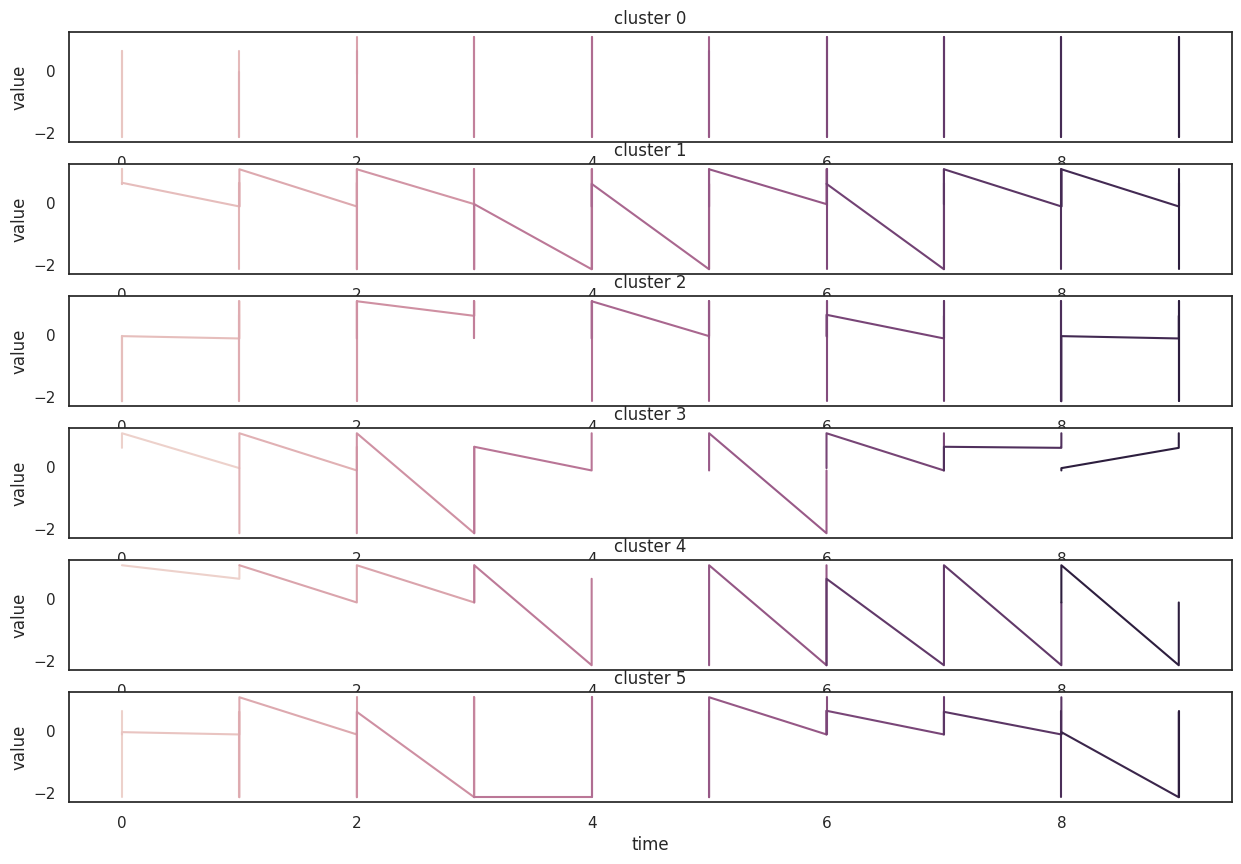

In [ ]:
!pip install seaborn --upgrade # update seaborn to latest version to enable lineplot

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

num_cluster = len(set(y_pred_hac_lcs))
sensor = 22

f, axis = plt.subplots(num_cluster, 1, figsize=(15, 10))
for c in range(num_cluster):
    index = y_pred_hac_dtw == c
    cluster_chunks = pd.DataFrame([chunk[sensor].reset_index(drop=True)
                                   for chunk, flag in zip(sample, index)
                                   if flag]).to_numpy()

    # Reshape data into long-form
    df = pd.DataFrame(cluster_chunks).melt(var_name='time', value_name='value')
    df['unit'] = df.index // cluster_chunks.shape[1]  # Create unit identifier

    # Use sns.lineplot with long-form data and 'unit' for hue
    sns.lineplot(data=df, x='time', y='value', hue='unit',
                 estimator=None, ax=axis[c], legend=False)
    axis[c].set_title('cluster ' + str(c))

<ipython-input-30-55a646fa0cbd>:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  links = scipy.cluster.hierarchy.linkage(lcs_distances, method='ward')


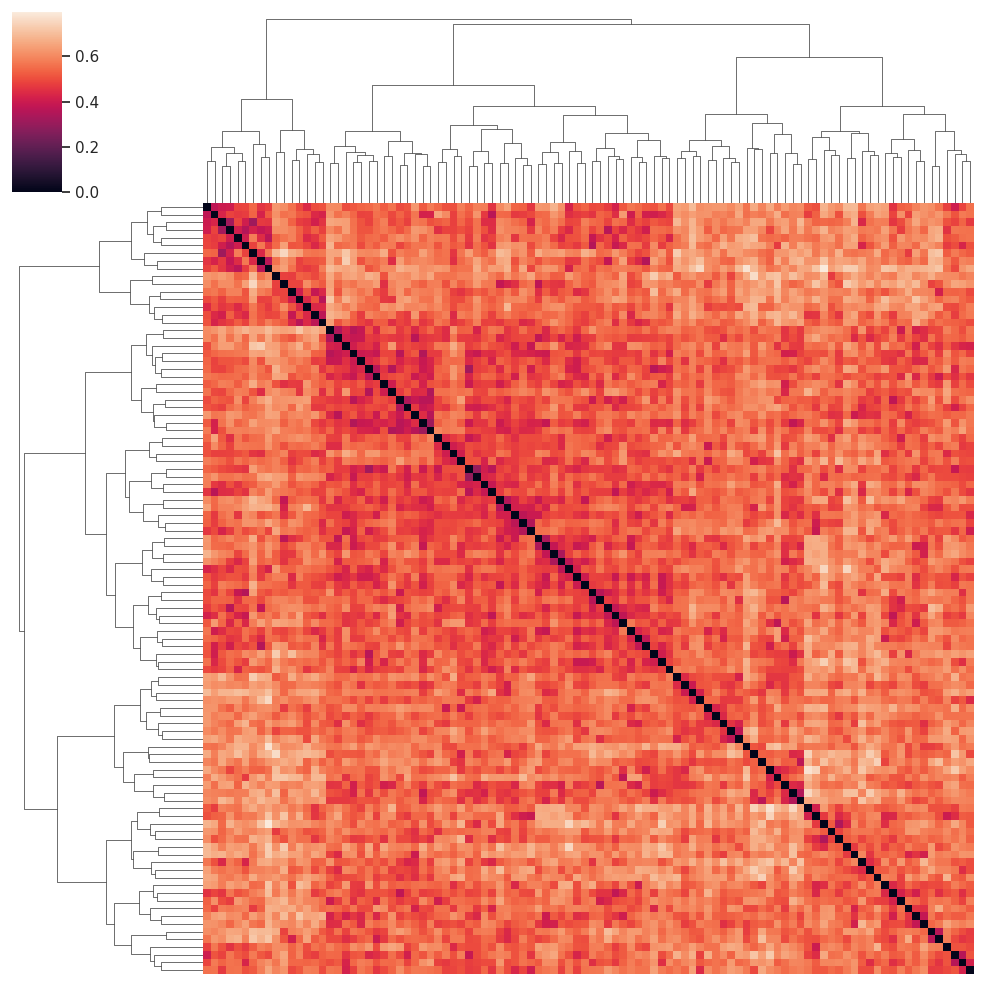

In [ ]:
# compute linkage matrix for HAC clusters
links = scipy.cluster.hierarchy.linkage(lcs_distances, method='ward')
sns.clustermap(lcs_distances, xticklabels=False, yticklabels=False,
               method='ward', col_linkage=links, row_linkage=links)